<a href="https://colab.research.google.com/github/LuluW8071/Ocular-Eye-Disease-Classification/blob/main/Multiple_Eye_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [5]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [6]:
!nvidia-smi

Sun Feb 25 13:52:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get Data

#### [Original Datasets](https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k)
Available is on Kaggle (click on above headline) which contains

|  Eye Disease    | Count  |
|-----------------|--------|
| Normal          | 2873   |
| Diabetes        | 1608   |
| Glaucoma        | 568    |
| Cataract        | 586    |
| Age-related     | 532    |
| Hypertension    | 256    |
| Myopia          | 464    |
| Other           | 708    |


#### [Custom Datasets](https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg)
Available on drive link (click on above headline) which were preprocessed and augmented using random crop, shear zoom in and zoom out, noneye images were added which contains random objects, aimals and plants images.

| Eye Disease | Train Dataset | Test Dataset |
|-------------|---------------|--------------|
| Glaucoma    | 2016          | 200          |
| Non-Eye     | 1985          | 200          |
| Normal      | 2101          | 200          |
| Cataract    | 2052          | 200          |
| AMD         | 1858          | 200          |
| Myopia      | 2008          | 200          |


In [7]:
import gdown
import zipfile
import os

file_url = 'https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg'
file_name = 'eye_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg
From (redirected): https://drive.google.com/uc?id=1iNJpbR5LSsOUBZ-MYeavqJyRBMjSC8yg&confirm=t&uuid=fa8e0c5c-cdc2-45c7-a203-5f985c25d4a7
To: /content/eye_dataset.zip
100%|██████████| 217M/217M [00:04<00:00, 47.0MB/s]


Files extracted successfully to: ./dataset


In [8]:
from pathlib import Path
import os

# Setup path to data folder
image_path = Path("/content/dataset/Eye_Diseases")

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/dataset/Eye_Diseases'.
There are 6 directories and 0 images in '/content/dataset/Eye_Diseases/test'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/glucoma'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/noneye'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/normal'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/cataract'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/amd'.
There are 0 directories and 200 images in '/content/dataset/Eye_Diseases/test/myopia'.
There are 6 directories and 0 images in '/content/dataset/Eye_Diseases/train'.
There are 0 directories and 2016 images in '/content/dataset/Eye_Diseases/train/glucoma'.
There are 0 directories and 1985 images in '/content/dataset/Eye_Diseases/train/noneye'.
There are 0 directories and 2101 images in '/content/dataset/Eye_Dise

## 2. Data Preparation (Visualization)

Random image path: /content/dataset/Eye_Diseases/train/noneye/935.jpg
Image Class: noneye
Image Height: 224
Image Width: 224


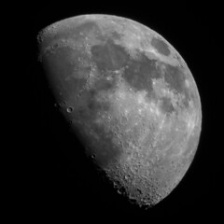

In [9]:
import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(len(image_path_list))
random_image_path = random.choice(image_path_list)
# print(random_image_path)
# the image class is the name of the directory where iamges resides
image_class = random_image_path.parent.stem
# print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

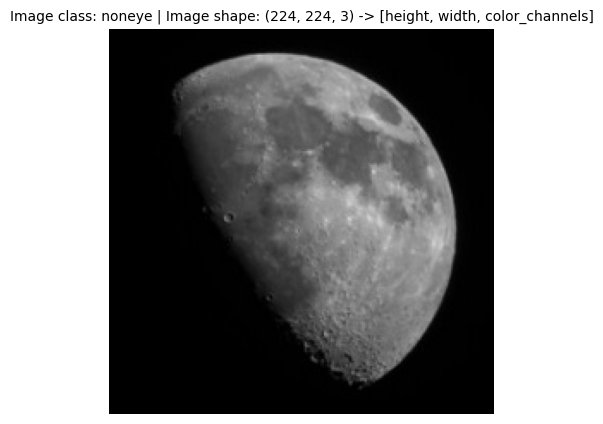

In [10]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(6, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]", fontsize = 10)
plt.axis(False)
plt.show()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
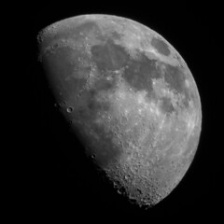

In [11]:
img_as_array

## 3. Transforming data

In [12]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

# Transform image
data_transform = transforms.Compose([
    # Resize our images to 224x224
    # transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])


transformed_data = data_transform(img)
transformed_data, transformed_data.shape, transformed_data.dtype

0.16.0+cu121


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.Size([3, 224, 224]),
 torch.float32)

## 4. Loading data with `ImageFolder`

In [13]:
# Setup train and test paths
train_dir = 'dataset/Eye_Diseases/train'
test_dir = 'dataset/Eye_Diseases/test'

train_dir, test_dir

('dataset/Eye_Diseases/train', 'dataset/Eye_Diseases/test')

In [14]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 12020
     Root location: dataset/Eye_Diseases/train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1200
     Root location: dataset/Eye_Diseases/test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [15]:
# Get class names as lists
class_names = train_data.classes
class_names

['amd', 'cataract', 'glucoma', 'myopia', 'noneye', 'normal']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'amd': 0, 'cataract': 1, 'glucoma': 2, 'myopia': 3, 'noneye': 4, 'normal': 5}

In [17]:
train_data.samples[:12000:2000]

[('dataset/Eye_Diseases/train/amd/102_left.jpg', 0),
 ('dataset/Eye_Diseases/train/cataract/2139_right.jpg', 1),
 ('dataset/Eye_Diseases/train/glucoma/1269_right.jpg', 2),
 ('dataset/Eye_Diseases/train/myopia/1543_right.jpg', 3),
 ('dataset/Eye_Diseases/train/noneye/067.jpg', 4),
 ('dataset/Eye_Diseases/train/normal/2365_left.jpg', 5)]

In [18]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.float32,
 0,
 int,
 'amd')

In [19]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 224, 224]), torch.Size([224, 224, 3]))

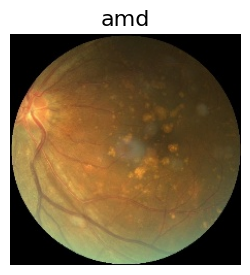

In [20]:
# Plot the image
plt.figure(figsize = (3, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16);

## 5. Turn loaded images into `Dataloaders`

In [21]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(376, 38)

In [22]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 6. Build Model from scratch using `TinyVGG` as Base Model

<img src = "https://miro.medium.com/v2/resize:fit:850/1*B_ZaaaBg2njhp8SThjCufA.png">

In [23]:
class ImprovedTinyVGGModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(ImprovedTinyVGGModel, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4 * hidden_units),
            # nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units),
            nn.Dropout(0.2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape),
            # nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1176, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.classifier(x)
        return x

In [24]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [25]:
from torchinfo import summary

# Instance of Improved TinyVGG
model = ImprovedTinyVGGModel(3, 48, len(class_names)).to(device)   # (input_shape, hidden_units, output_shape)
summary(model, input_size = [1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedTinyVGGModel                     [1, 6]                    --
├─Sequential: 1-1                        [1, 48, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 48, 224, 224]         1,344
│    └─ReLU: 2-2                         [1, 48, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 48, 224, 224]         20,784
│    └─ReLU: 2-4                         [1, 48, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 48, 112, 112]         --
│    └─BatchNorm2d: 2-6                  [1, 48, 112, 112]         96
│    └─Dropout: 2-7                      [1, 48, 112, 112]         --
├─Sequential: 1-2                        [1, 192, 56, 56]          --
│    └─Conv2d: 2-8                       [1, 192, 112, 112]        83,136
│    └─ReLU: 2-9                         [1, 192, 112, 112]        --
│    └─Conv2d: 2-10                      [1, 192, 112, 112]        331,968

In [26]:
# Trying forward pass to check the model
model(img.to(device))

tensor([[ 8.5040e-02, -3.1208e-03,  2.8156e-01,  1.4778e-01,  1.6273e-01,
          6.9620e-02],
        [ 5.8027e-01, -4.0843e-01, -9.8940e-02,  1.1109e-01,  2.0684e-01,
          3.6002e-03],
        [ 4.2017e-01, -1.5005e-01, -9.4117e-02,  1.6373e-01,  1.9767e-01,
         -3.0725e-01],
        [ 5.1104e-01, -2.6174e-01, -4.4551e-02,  1.7109e-01,  6.1106e-02,
          1.1507e-01],
        [ 4.6936e-01,  6.7145e-02,  2.1220e-01,  2.3293e-02, -5.6148e-02,
         -1.5689e-02],
        [ 6.2351e-02, -2.5294e-01,  1.3922e-01,  3.3198e-01, -2.0955e-01,
          3.1184e-01],
        [ 4.8329e-01, -2.8033e-01,  5.0983e-02,  2.0343e-01,  1.2341e-01,
          2.5190e-01],
        [ 2.9313e-01, -1.0285e-01,  2.6225e-02,  6.7172e-02,  7.3502e-02,
         -3.8343e-02],
        [-1.5051e-01, -5.6500e-01,  5.8685e-02, -1.1587e-01, -6.4090e-02,
          4.0870e-01],
        [ 6.9371e-02, -1.1663e-01,  2.2643e-01,  2.1907e-02, -2.3789e-01,
          2.6372e-02],
        [ 4.7440e-01, -2.6793e

## 7. Create Train/Test Loop Function

In [27]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [28]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 8. Train and Evaluate the Model

In [29]:
# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [30]:
# Set random seed
# torch.manual_seed(42)
EPOCHS = 50

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2188 - Train acc: 50.61% -  Test loss: 1.0496 - Test acc: 56.25%
Epoch: 1 | Train loss: 1.0255 - Train acc: 59.14% -  Test loss: 0.8683 - Test acc: 67.52%
Epoch: 2 | Train loss: 0.9353 - Train acc: 64.28% -  Test loss: 0.8094 - Test acc: 67.19%
Epoch: 3 | Train loss: 0.8651 - Train acc: 67.46% -  Test loss: 0.8335 - Test acc: 67.52%
Epoch: 4 | Train loss: 0.8171 - Train acc: 69.73% -  Test loss: 0.7605 - Test acc: 71.71%
Epoch: 5 | Train loss: 0.7554 - Train acc: 72.02% -  Test loss: 0.7003 - Test acc: 74.51%
Epoch: 6 | Train loss: 0.7212 - Train acc: 73.38% -  Test loss: 0.6000 - Test acc: 78.29%
Epoch: 7 | Train loss: 0.7039 - Train acc: 74.48% -  Test loss: 0.6072 - Test acc: 78.04%
Epoch: 8 | Train loss: 0.6772 - Train acc: 75.18% -  Test loss: 0.5358 - Test acc: 81.58%
Epoch: 9 | Train loss: 0.6658 - Train acc: 75.70% -  Test loss: 0.5219 - Test acc: 80.51%
Epoch: 10 | Train loss: 0.6340 - Train acc: 77.05% -  Test loss: 0.4912 - Test acc: 82.73%
Epoch: 11

Try running more epochs to see better results :)

## 9. Plot `loss curves` and `accuracy curves`

In [31]:
# Get the model key results
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [32]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary """

    # Get results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

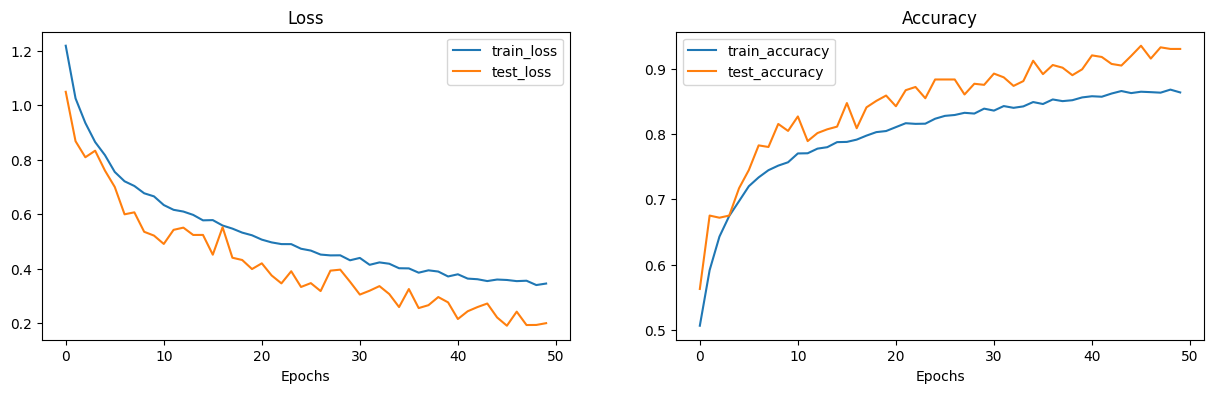

In [33]:
plot_loss_curves(model_results)

## 10. Saving Model

In [37]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "MultipleEyeDiseaseDetectModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/MultipleEyeDiseaseDetectModel.pth


## 11. Loading Model

In [38]:
loaded_model = ImprovedTinyVGGModel(3, 48, 6).to('cpu')
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
ImprovedTinyVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(192, 

## 12. Making Predictions on Loaded Model

In [39]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [40]:
import random
# random.seed(42)

test_samples = []
test_labels = []
# test_targets_tensor = torch.tensor(test_data.targets)
for sample, label in random.sample(list(test_data), k = 20):
  test_samples.append(sample)
  test_labels.append(label)

In [41]:
test_samples[0].shape

torch.Size([3, 224, 224])

In [42]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

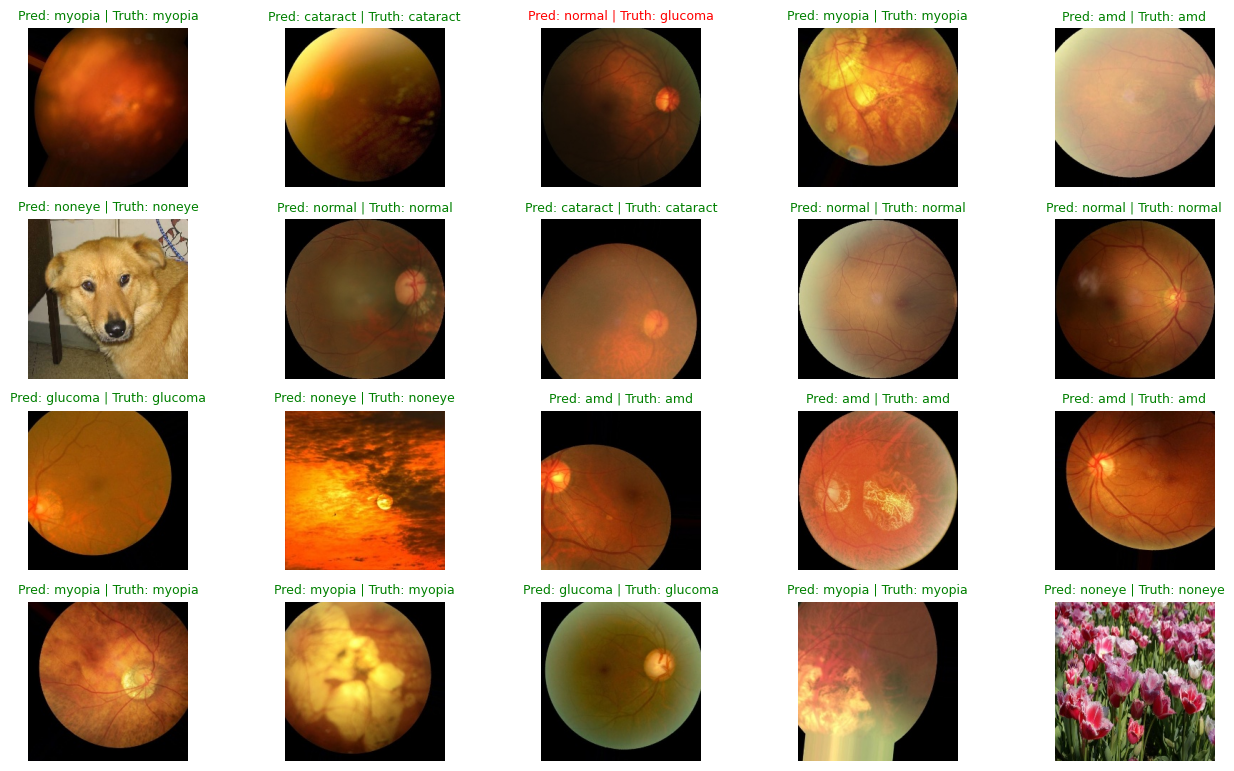

In [43]:
plt.figure(figsize=(16, 12))
nrows, ncols = 5, 5

for i, sample in enumerate(test_samples):
  class_name = np.array(['amd', 'cataract', 'glucoma', 'myopia', 'noneye', 'normal'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  # normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)

  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);